In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

In [3]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [4]:
y.shape, tx.shape

((10000,), (10000, 2))

# 1. Computing the Cost Function

### to understand this data format, answer to the following warmup question

Let's use linear model where we will use height as input ($x$) and weight as output ($y$).

$y_n = w_0 + w_1\cdot x_{n1}$

#### What does each column of tx represent ?
each column of tx represent a dimension of the input $x$. So we should get $D$ column. Here we have $D+1$ columns because of the litle $w_0$ trick we see in class (see next question)

#### What does each row of tx represent ?
each row of tx is an input sample. 

#### Why do we have 1's in tx ?
We have 1's because of the litle trick we use to put the $w_0$ inside the matrix multiplication. $w_0$ is multiplicated with $1$ and we get $w_0 +  w_1x_1 + ...+ w_nx_n$.

#### If we have heights and weights of 3 people, what would be the size of y and tx ? What would tx_32 represent ?
If we have 3 inputs, we get 3 row in tx and then also 3 row in y. Because this model implies only 1 input dimension and we have D+1 column in tx. tx is a 3 rows 2 column and y a 3 rows 1 column. 

I suppose $tx_{32}$ is the element at the third row and the second column of $tx$. So it would be the height of the third sample




### Exercise 1

#### a) 
Now we will compute the MSE. Let us introduce the vector notation $e = y − tx\cdot w$ , for given model parameters $w =[w_10, w_1]^T$. Prove that the MSE can also be rewritten in terms of the vector e, as $L(w) = ...$

$e= y -tx\cdot w \rightarrow e_n = y_n - x_n\cdot w = y_n - (w_0x_0+w_1x_1) = y_n -w_0 - w_1x_1$

so

$L(w) = \frac{1}{2N}\sum_{n=1}^N e_n^2$

#### b) 

Fill in the the `compute_cost(y, tx, w)` function below, and test it with $w=[1, 2]^T$:

In [5]:
def compute_loss(y, tx, w):
   
    y = y.reshape(-1, 1)
    w = w.reshape(-1, 1)
    
    print(y.shape)
    print(tx.shape)
    print(w.shape)

    e = y - tx.dot(w)

    L = 1/(2*y.shape[0]) * np.square(e).sum()
    #print(L)
    
    return L

w = np.array([1, 2])
compute_loss(y, tx, w)

(10000, 1)
(10000, 2)
(2, 1)


2694.4833658870843

# 2. Grid Search

Fill in the function `grid_search()` below:

In [5]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss for each combination of w0 and w1.
    
    for i in range(len(w0)):
        
        for j in range(len(w1)):
            
            losses[i][j] = compute_loss(y, tx, np.array([w0[i], w1[j]]))   
    
    
    # ***************************************************
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=42.42448314678248, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.011 seconds


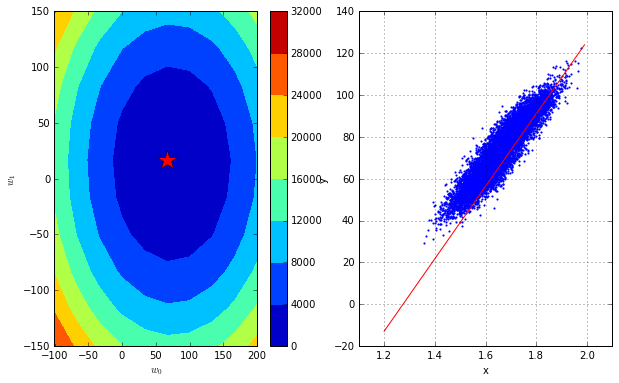

In [6]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization
import datetime

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

### b)

We don't have here a good estimate. Having a look on the right graph we feel the red ligne not so good. As we can see, the left graph is not smooth because we are taking only a few value of w0 and w1. 

As we know MSE convex we deduce the minimum inside the dark blue zone, but this zone is not well defined. 

We can inprove the results by increase the number of w0 and w1 value (increase the grid). This will take more calculation time but probably give better loss*. 

More of that we could reduce the w0 and w1 intervals, taking for example w0 from -50 to 150 in the first time. 





# 3. Gradient Descent

### a)

Again, please fill in the functions `compute_gradient` below:

In [31]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""

    
    y = y.reshape(-1, 1)
    w = w.reshape(-1, 1)
    
    e = y - tx.dot(w)

    gradL = -1/y.shape[0] * (tx.transpose().dot(e))

    return gradL



### b)

get some intuition about the gradient values : so I compute the gradient for : 

$w_0 = 100$ and $w_1 = 20$

$w_0=50$ and $w_1 = 10$

In [30]:
print(compute_gradient(y, tx, np.array([100, 20])))
print("\n")
print(compute_gradient(y, tx, np.array([50, 10])))

(10000,)
(10000, 2)
[[ 26.706078  ]
 [  6.52028757]]


(10000,)
(10000, 2)
[[-23.293922  ]
 [ -3.47971243]]


The gradient is the variation of a function with respect of its parameters variation. It expresse how quickly does $L(w)$ change depending on variable $w$

The gradient of a local extremum is 0. 


### c)
Please fill in the functions `gradient_descent` below:

In [9]:
def gradient_descent(y, tx, initial_w, max_iters, gamma): 
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    y = y.reshape(-1, 1)
    initial_w = initial_w.reshape(-1, 1)
    
    ws = [initial_w]
    losses = []
    w = initial_w
        
    for n_iter in range(max_iters):
        
        #compute gradient and loss
        loss = compute_loss(y, tx, w)
        gradient = compute_gradient(y, tx, w)    
        
        #update w by gradient
        w = w - gamma * gradient
        
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [10]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 10
gamma = 0.99

# Initialization
w_initial = np.array([-1000.0, 1000.0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/9): loss=1062606.4462798769, w0=[ 62.56098278], w1=[ 23.34491531]
Gradient Descent(1/9): loss=121.64499390798603, w0=[ 73.18659261], w1=[ 13.57836446]
Gradient Descent(2/9): loss=15.396513779433311, w0=[ 73.29284871], w1=[ 13.48069896]
Gradient Descent(3/9): loss=15.38588893142046, w0=[ 73.29391127], w1=[ 13.4797223]
Gradient Descent(4/9): loss=15.38588786893566, w0=[ 73.29392189], w1=[ 13.47971253]
Gradient Descent(5/9): loss=15.38588786882941, w0=[ 73.293922], w1=[ 13.47971244]
Gradient Descent(6/9): loss=15.385887868829402, w0=[ 73.293922], w1=[ 13.47971243]
Gradient Descent(7/9): loss=15.385887868829402, w0=[ 73.293922], w1=[ 13.47971243]
Gradient Descent(8/9): loss=15.385887868829402, w0=[ 73.293922], w1=[ 13.47971243]
Gradient Descent(9/9): loss=15.385887868829402, w0=[ 73.293922], w1=[ 13.47971243]
Gradient Descent: execution time=0.017 seconds


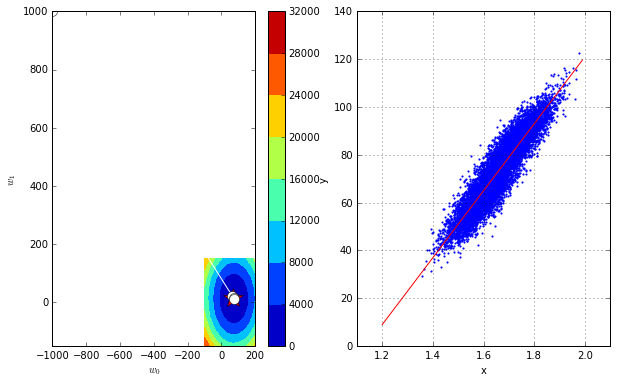

In [11]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

The cost seems to be minimized, because from step 44 to 49 from the descend algorithm, the cost is not improved any more with this kind of precision. So the gradient must be very small (very very close to zero). So we see the algorithm is converging, and the convergence speed is not so bad because "only" 45 steps are mandatory in our case to reach nearly the fixed point. We will see in d) if we can be faster 

the final values of w is pretty good for me. the intuition of the red line in the right graph show it. 

### d)

Let just varying the $\gamma$ value. 

let $\gamma = 0.001$, the algorithm converge also but need a lot of steps I ve tried 10000 and the algorithm has still not reach the fixed point.  

let $\gamma = 0.01$ ,the algorithm converge also and need less steps (about 1000) to reach the fixed point

let $\gamma = 0.5$, the algorithm reachs the fixed point after 33 steps, so better than the default 0.4. 

let $\gamma = 1$, the algorithm reachs the fixed point in 1 step, certainly the best gamma parameter we could choose

let $\gamma = 2$, the algorithm jump here, it's not converging any more. keeping the same loos it switch at each step from a wA to a wB and back to wA

let $\gamma = 2.5$, this time the alogrithm diverges to astronomical values from step to step.  


now we fix $\gamma=0.1$ and we varying $w_0$ and $w_1$

$w_0 = 0$ and $w_1 = 0$, the algorithm converge with aprox 220 step. 

$w_0 = 100$ and $w_1 = 10$, the algorithm also converge with aprox 220 setp too

$w_0 = -1000$ and $w_1 = 1000$, the algorithm need a bit more step (250) but still converging.

I deduce the starting $w$ is not very important because after few step we are already in the neighborhood of the fixed point. In our case the best are for 
$w_0 \approx 73.29$ and $w_1 \approx 13.50$, we need less steps to pass from 1000 to 73 than from 73 to 73.29  

# 4. Stochastic gradient descent

In [79]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient for batch data."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient computation.It's same as the gradient descent.
    # ***************************************************
    
    y = y.reshape(-1, 1)
    w = w.reshape(-1, 1)
    
    e = y - tx.dot(w)

    gradL = -1/y.shape[0] * (tx.transpose().dot(e))

    return gradL


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_epochs, gamma):
    """Stochastic gradient descent algorithm."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient descent.
    # ***************************************************
    
    # Define parameters to store w and loss
    y = y.reshape(-1, 1)
    initial_w = initial_w.reshape(-1, 1)
    
    ws = [initial_w]
    losses = []
    w = initial_w
        
    for n_iter in range(max_epochs):
        
        #compute gradient and loss
        j = 0   
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size, num_batches=5):
            j+=1
            gradient = compute_stoch_gradient(minibatch_y, minibatch_tx, w) 
            loss = compute_loss(minibatch_y, minibatch_tx, w)
            
            #update w by gradient
            w = w - gamma * gradient
        
            # store w and loss
            ws.append(np.copy(w))
            losses.append(loss)
            print("Gradient Descent(epoch :{bi}/{ti}): minibatch={m} loss={l}, w0={w0}, w1={w1}".format(
                  bi=n_iter, ti=max_iters - 1, m=j, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [82]:
# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.6
batch_size = 5

# Initialization
w_initial = np.array([0.0, 0.0])

# Start SGD.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = stochastic_gradient_descent(y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(epoch :0/49): minibatch=1 loss=2436.771307707587, w0=[ 41.02988309], w1=[-11.62851435]
Gradient Descent(epoch :0/49): minibatch=2 loss=1344.7454531950825, w0=[ 69.11821727], w1=[ 9.88886138]
Gradient Descent(epoch :0/49): minibatch=3 loss=13.955464906122334, w0=[ 71.19593322], w1=[ 12.11371981]
Gradient Descent(epoch :0/49): minibatch=4 loss=37.380260839188935, w0=[ 73.71789785], w1=[ 11.87446033]
Gradient Descent(epoch :0/49): minibatch=5 loss=6.458231801850129, w0=[ 73.83956202], w1=[ 11.32419939]
Gradient Descent(epoch :1/49): minibatch=1 loss=21.298432412396906, w0=[ 73.18885889], w1=[ 12.01833485]
Gradient Descent(epoch :1/49): minibatch=2 loss=33.021599130310754, w0=[ 74.82381403], w1=[ 14.03563374]
Gradient Descent(epoch :1/49): minibatch=3 loss=23.2172067565181, w0=[ 71.5414504], w1=[ 14.18548047]
Gradient Descent(epoch :1/49): minibatch=4 loss=12.792520733011246, w0=[ 73.80768441], w1=[ 13.85390725]
Gradient Descent(epoch :1/49): minibatch=5 loss=33.3895507467

<function __main__.plot_figure>

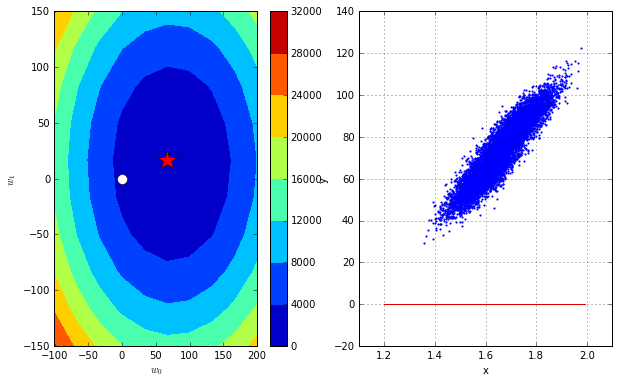

In [81]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))